### *Required Library*

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
import ydata_profiling as pf
import datetime as dt
import joblib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### *DataSet*

In [2]:
data=pd.read_csv("E:\Data Science\Datasets\Flight Train Data.csv")
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24-03-2019,Banglore,New Delhi,BLR?DEL,22:20,22-03-2023 01:10,2h 50m,non-stop,No info,3897
1,Air India,01-05-2019,Kolkata,Banglore,CCU?IXR?BBI?BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,09-06-2019,Delhi,Cochin,DEL?LKO?BOM?COK,09:25,10-06-2023 04:25,19h,2 stops,No info,13882
3,IndiGo,12-05-2019,Kolkata,Banglore,CCU?NAG?BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01-03-2019,Banglore,New Delhi,BLR?NAG?DEL,16:50,21:35,4h 45m,1 stop,No info,13302


### *Automated EDA*

In [3]:
pf.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### *Manual EDA*

In [4]:
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [5]:
data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [6]:
data.dropna(how='any',inplace=True)
data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

### *Feature Engineering*

In [7]:
data['Date_of_Journey']=pd.to_datetime(data['Date_of_Journey'])
data['Day_of_Journey']=data['Date_of_Journey'].dt.day
data['Month_of_Journey']=data['Date_of_Journey'].dt.month

In [8]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR?DEL,22:20,22-03-2023 01:10,2h 50m,non-stop,No info,3897,24,3
1,Air India,2019-05-01,Kolkata,Banglore,CCU?IXR?BBI?BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL?LKO?BOM?COK,09:25,10-06-2023 04:25,19h,2 stops,No info,13882,9,6
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU?NAG?BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR?NAG?DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


### *Formatting Date Of Journey*

In [9]:
data.drop(['Date_of_Journey'],axis=1,inplace=True)

### *Formatting Departure Time*

In [10]:
data['Dep_hr']=pd.to_datetime(data['Dep_Time']).dt.hour
data['Dep_min']=pd.to_datetime(data['Dep_Time']).dt.minute

### *Formatting Arrival Time*

In [11]:
data['Arr_hr']=pd.to_datetime(data['Arrival_Time'],format='mixed').dt.hour
data['Arr_min']=pd.to_datetime(data['Arrival_Time'],format='mixed').dt.minute

In [12]:
data.drop(['Dep_Time'],axis=1,inplace=True)
data.drop(['Arrival_Time'],axis=1,inplace=True)

### *Formatting Duration*

In [13]:
duration=data['Duration'].str.split(' ',expand=True)

In [14]:
duration

,0,1
0,2h,50m
1,7h,25m
2,19h,None
3,5h,25m
4,4h,45m
...,...,...
10678,2h,30m
10679,2h,35m
10680,3h,None
10681,2h,40m


In [15]:
duration.isna().sum()

0       0
1    1032
dtype: int64

In [16]:
duration[1].fillna('00m',inplace=True)

In [17]:
duration.isna().sum()

0    0
1    0
dtype: int64

In [18]:
data['Duration_hr']=duration[0].apply(lambda x:x[:-1])
data['Duration_min']=duration[1].apply(lambda x:x[:-1])

In [19]:
data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hr,Dep_min,Arr_hr,Arr_min,Duration_hr,Duration_min
0,IndiGo,Banglore,New Delhi,BLR?DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU?IXR?BBI?BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL?LKO?BOM?COK,19h,2 stops,No info,13882,9,6,9,25,4,25,19,00
3,IndiGo,Kolkata,Banglore,CCU?NAG?BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR?NAG?DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [20]:
data.drop('Duration',axis=1,inplace=True)

### *Count Of Airlines*

In [21]:
data['Airline'].value_counts()

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

### *Airline vs Price*

In [22]:
Airline_Prices=data.groupby(['Airline'])['Price'].mean().sort_values(ascending=False).reset_index()

In [23]:
Airline_Prices

,Airline,Price
0,Jet Airways Business,58358.666667
1,Jet Airways,11643.923357
2,Multiple carriers Premium economy,11418.846154
3,Multiple carriers,10902.678094
4,Air India,9612.427756
5,Vistara Premium economy,8962.333333
6,Vistara,7796.348643
7,GoAir,5861.056701
8,IndiGo,5673.682903
9,Air Asia,5590.260188


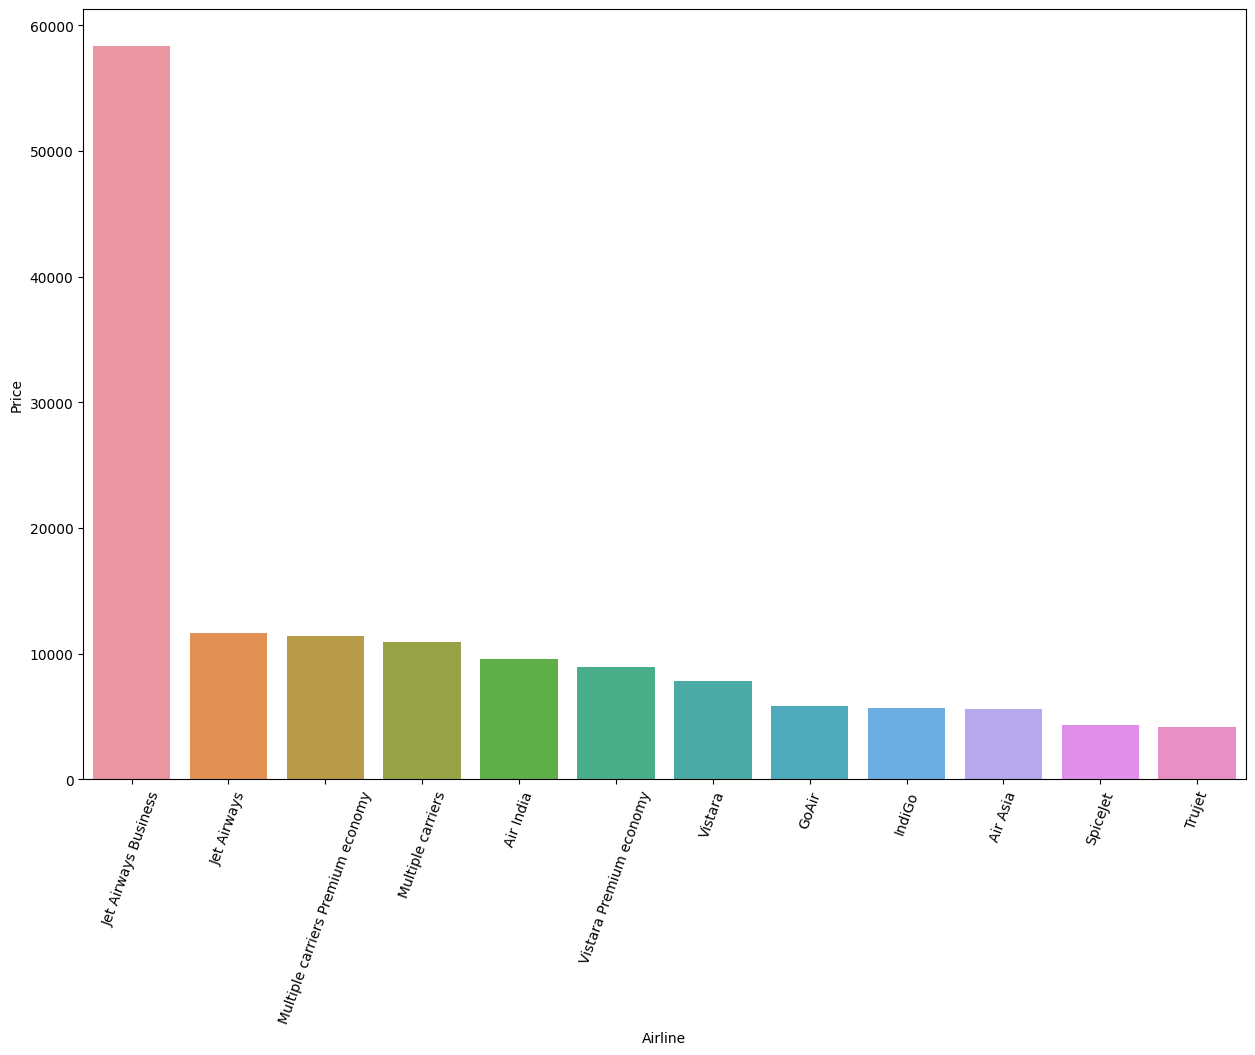

In [24]:
plt.figure(figsize=(15,10))
sns.barplot(Airline_Prices,x='Airline',y='Price')
plt.xticks(rotation=70)
plt.show()

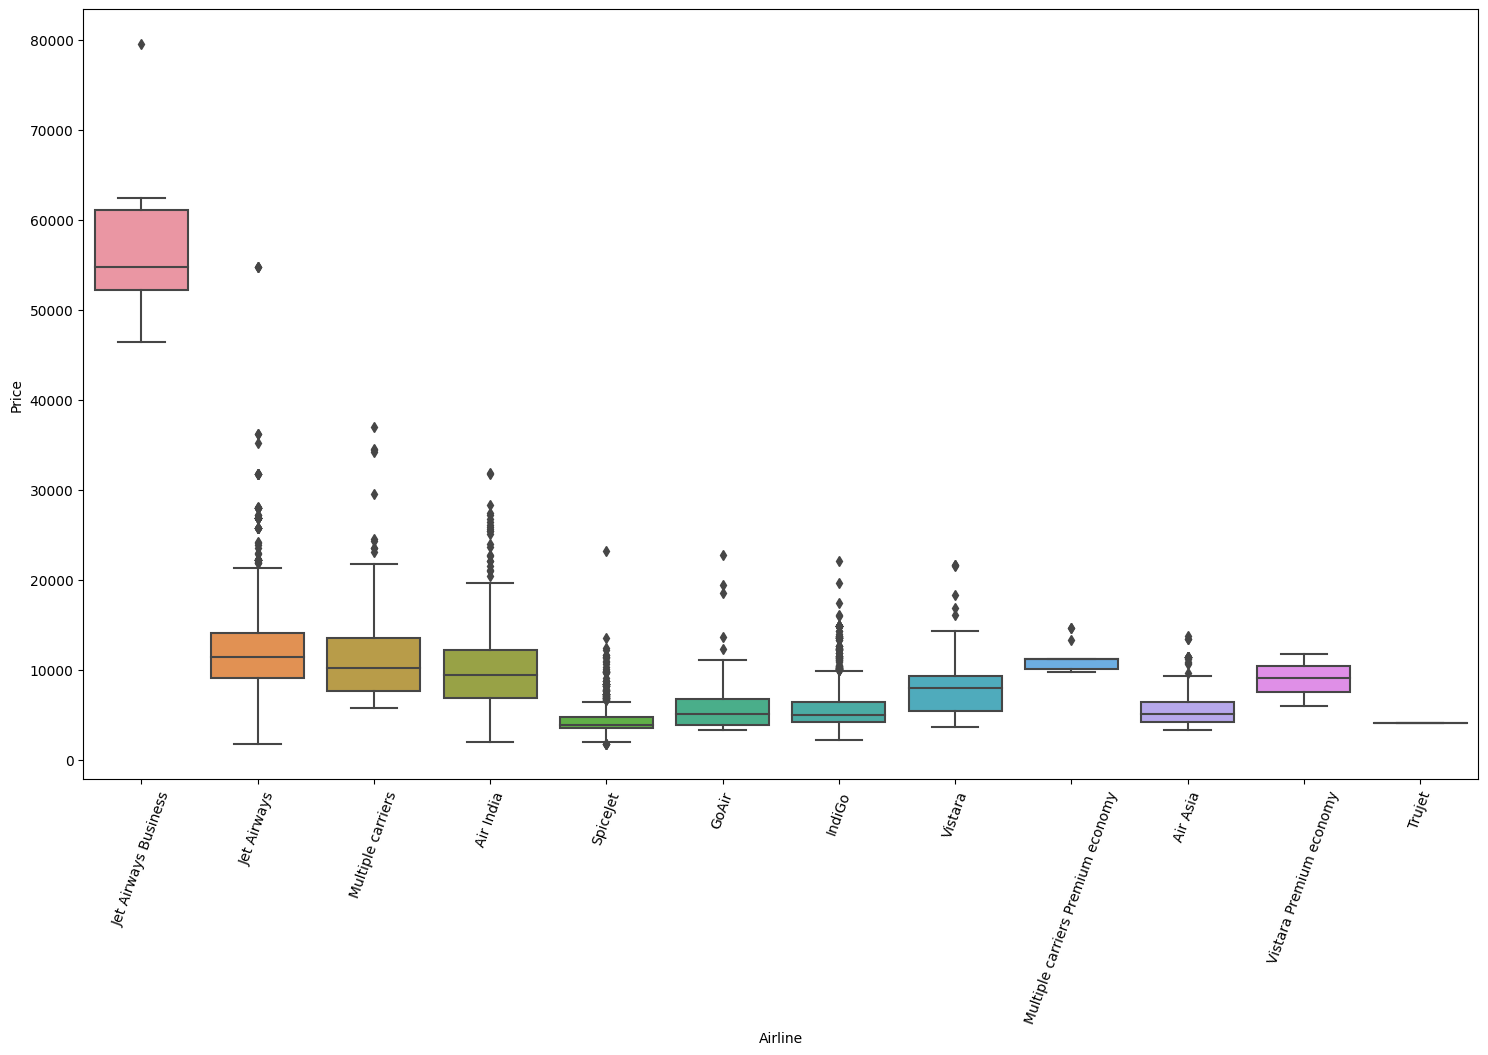

In [25]:
plt.figure(figsize=(18,10))
sns.boxplot(data=data.sort_values('Price',ascending=False),x='Airline',y='Price')
plt.xticks(rotation=70)
plt.show()

### *Price Based On No. Of Stops*

In [26]:
data.groupby(['Airline','Total_Stops'])['Price'].mean()

Airline                            Total_Stops
Air Asia                           1 stop          7078.325581
                                   2 stops         6341.888889
                                   non-stop        4492.331492
Air India                          1 stop          9041.509259
                                   2 stops        12092.779101
                                   3 stops        12208.054054
                                   4 stops        17686.000000
                                   non-stop        5605.326139
GoAir                              1 stop          6884.676471
                                   non-stop        4726.173913
IndiGo                             1 stop          7104.717528
                                   2 stops         7507.526316
                                   non-stop        4731.174053
Jet Airways                        1 stop         12512.741223
                                   2 stops        13387.247467
        

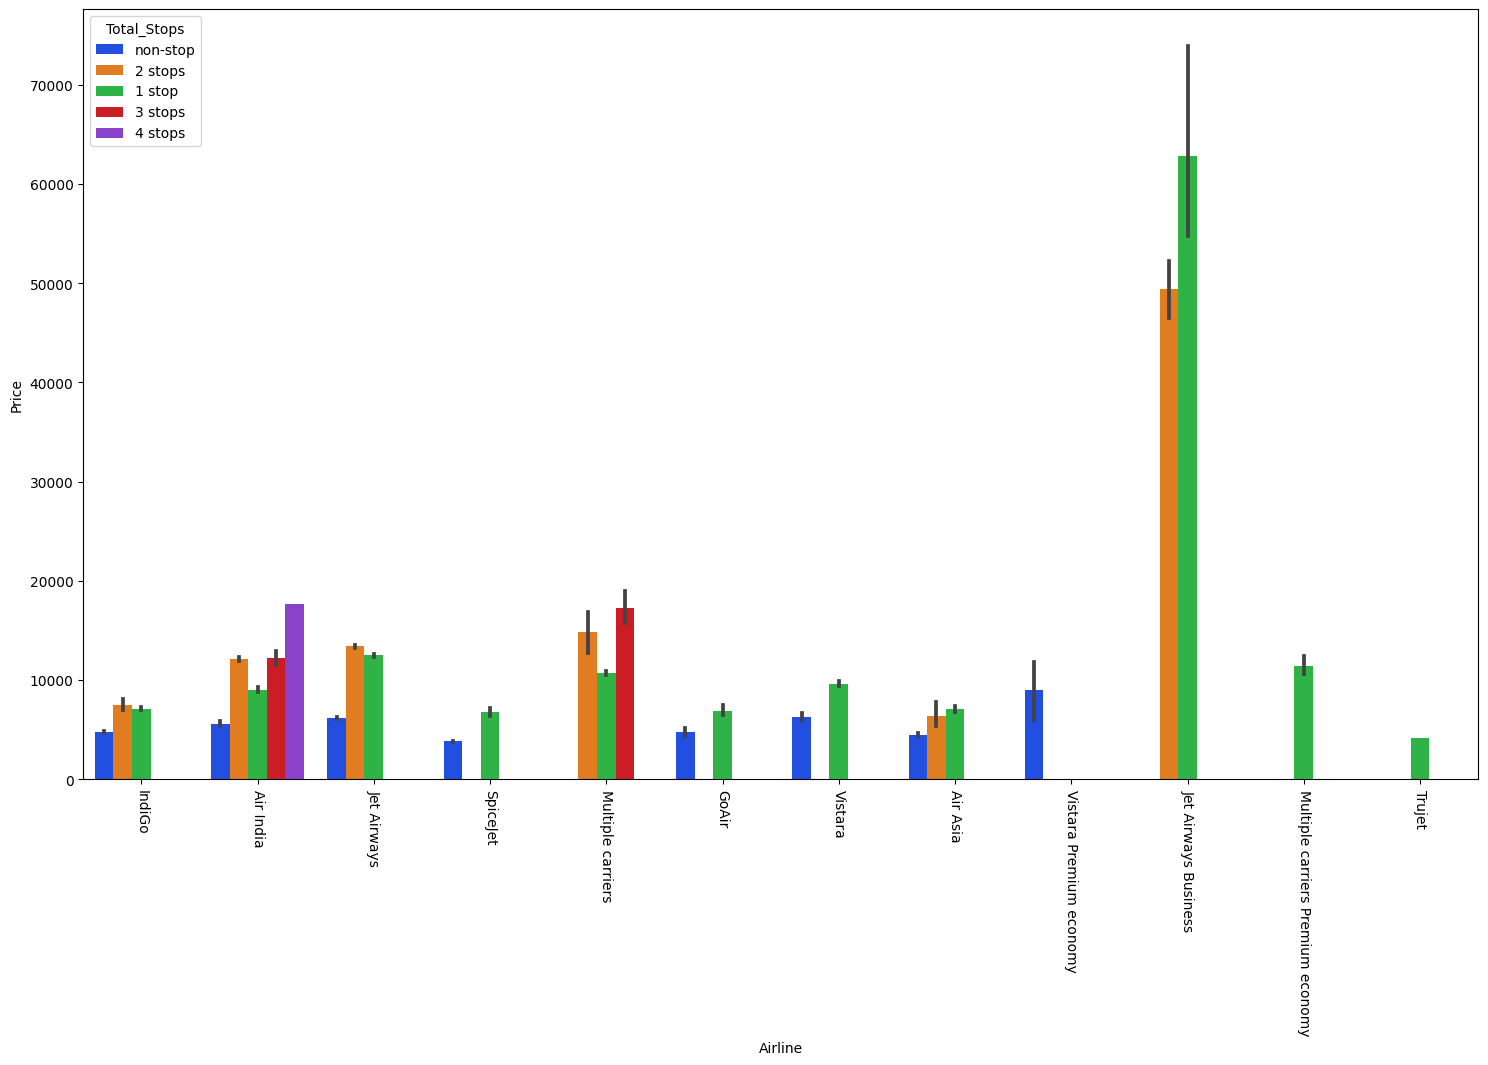

In [27]:
plt.figure(figsize=(18,10))
sns.barplot(data=data,x='Airline',y='Price',hue='Total_Stops',palette='bright')
plt.xticks(rotation=270)
plt.show()

### *Source vs Price*

In [28]:
data['Source'].value_counts()

Source
Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

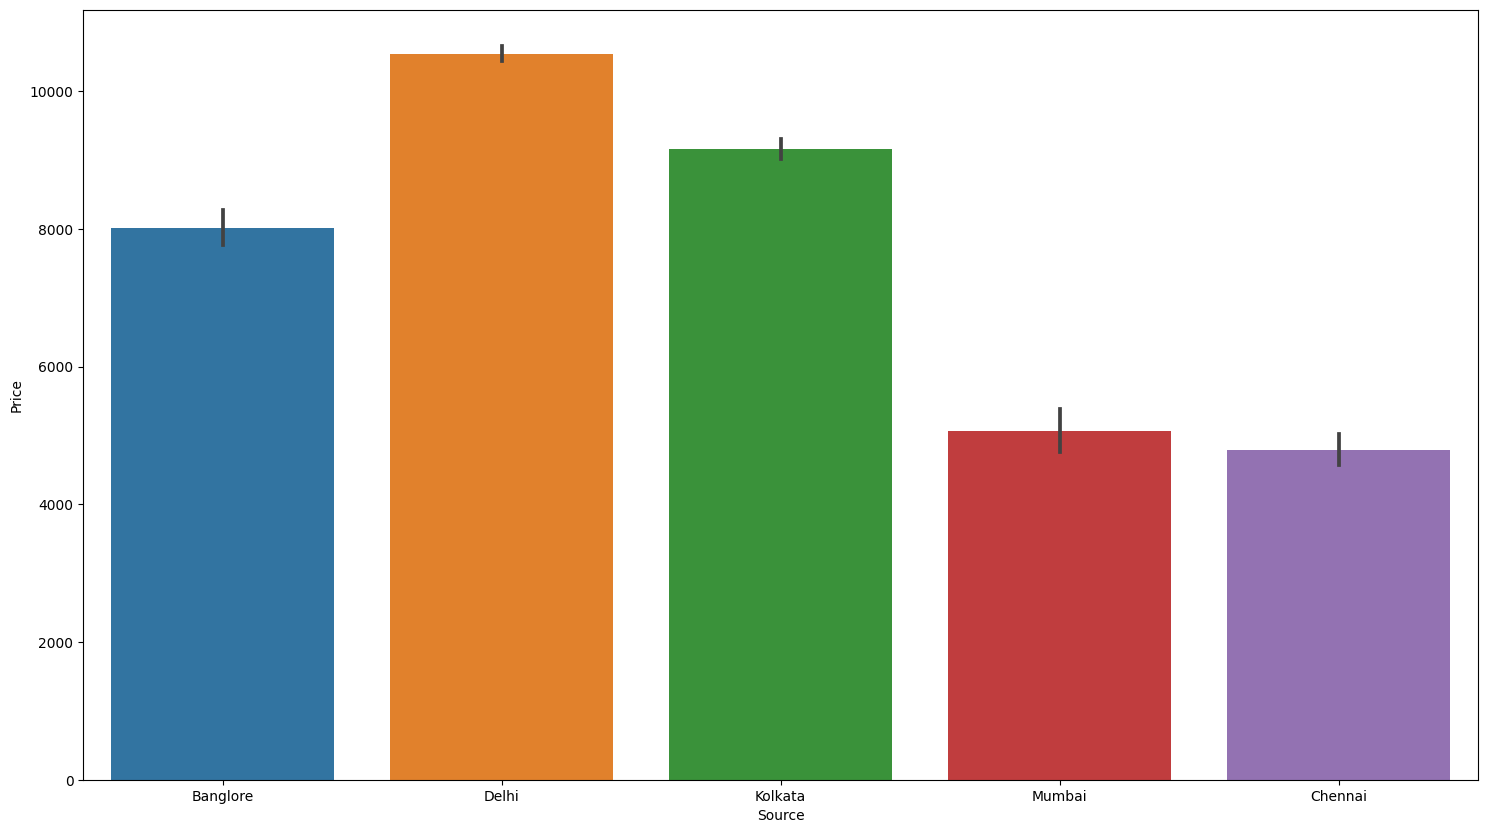

In [29]:
plt.figure(figsize=(18,10))
sns.barplot(data=data.sort_values('Price',ascending=False),x='Source',y='Price')
plt.show()

### *Destination vs Price*

In [30]:
data['Destination'].value_counts()

Destination
Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

In [31]:
for i in data:
    data.replace('New Delhi','Delhi',inplace=True)

In [32]:
data['Destination'].value_counts()

Destination
Cochin       4536
Banglore     2871
Delhi        2197
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

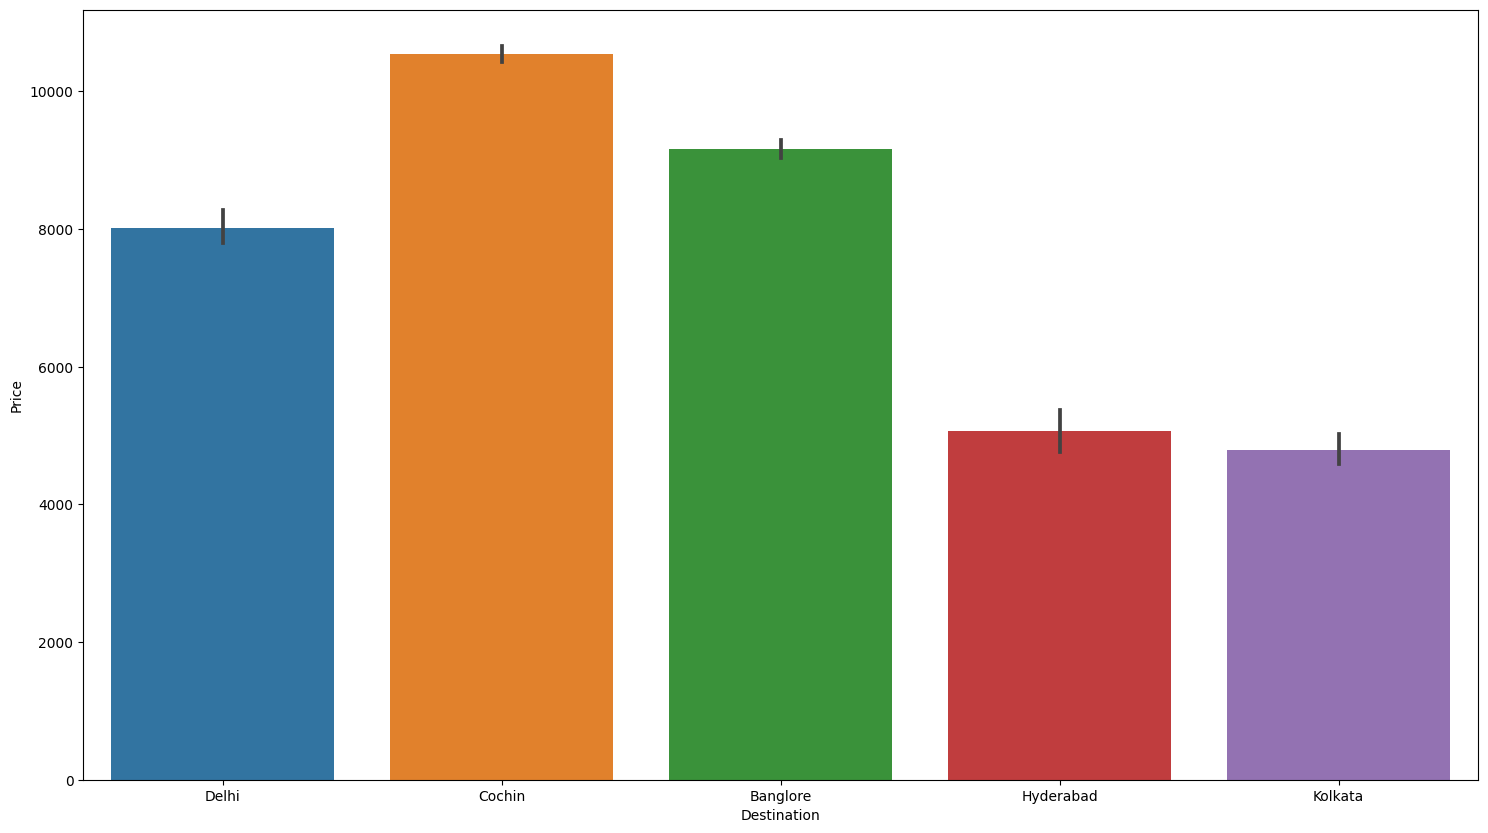

In [33]:
plt.figure(figsize=(18,10))
sns.barplot(data=data.sort_values('Price',ascending=False),x='Destination',y='Price')
plt.show()

### *One Hot Encoding*

In [34]:
data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Day_of_Journey,Month_of_Journey,Dep_hr,Dep_min,Arr_hr,Arr_min,Duration_hr,Duration_min
0,IndiGo,Banglore,Delhi,BLR?DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU?IXR?BBI?BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL?LKO?BOM?COK,2 stops,No info,13882,9,6,9,25,4,25,19,00
3,IndiGo,Kolkata,Banglore,CCU?NAG?BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,BLR?NAG?DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [35]:
data['Total_Stops']=data['Total_Stops'].replace({'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4})

In [36]:
Airline_dummy=pd.get_dummies(data['Airline'],drop_first=True,dtype=int)
Source_Destination_dummy=pd.get_dummies(data[['Source','Destination']],drop_first=True,dtype=int)

In [37]:
data=pd.concat([data,Airline_dummy,Source_Destination_dummy],axis=1)

In [38]:
data.drop(['Airline','Source','Destination'],axis=1,inplace=True)

In [39]:
data.dtypes

Route                                object
Total_Stops                           int64
Additional_Info                      object
Price                                 int64
Day_of_Journey                        int32
Month_of_Journey                      int32
Dep_hr                                int32
Dep_min                               int32
Arr_hr                                int32
Arr_min                               int32
Duration_hr                          object
Duration_min                         object
Air India                             int32
GoAir                                 int32
IndiGo                                int32
Jet Airways                           int32
Jet Airways Business                  int32
Multiple carriers                     int32
Multiple carriers Premium economy     int32
SpiceJet                              int32
Trujet                                int32
Vistara                               int32
Vistara Premium economy         

In [40]:
data.shape

(10682, 31)

### *Test Data*

In [41]:
test_data=pd.read_csv("E:\Data Science\Datasets\Flight Test Data.csv")
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR ? DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [42]:
data[['Duration_hr','Duration_min']]=data[['Duration_hr','Duration_min']].astype(int)

In [43]:
data.dtypes

Route                                object
Total_Stops                           int64
Additional_Info                      object
Price                                 int64
Day_of_Journey                        int32
Month_of_Journey                      int32
Dep_hr                                int32
Dep_min                               int32
Arr_hr                                int32
Arr_min                               int32
Duration_hr                           int32
Duration_min                          int32
Air India                             int32
GoAir                                 int32
IndiGo                                int32
Jet Airways                           int32
Jet Airways Business                  int32
Multiple carriers                     int32
Multiple carriers Premium economy     int32
SpiceJet                              int32
Trujet                                int32
Vistara                               int32
Vistara Premium economy         

In [44]:
x=data.drop(['Route','Price','Additional_Info'],axis=1)
y=data['Price']

In [45]:
x.head()

,Total_Stops,Day_of_Journey,Month_of_Journey,Dep_hr,Dep_min,Arr_hr,Arr_min,Duration_hr,Duration_min,Air India,...,Vistara,Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,24,3,22,20,1,10,2,50,0,...,0,0,0,0,0,0,0,1,0,0
1,2,1,5,5,50,13,15,7,25,1,...,0,0,0,0,1,0,0,0,0,0
2,2,9,6,9,25,4,25,19,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1,12,5,18,5,23,30,5,25,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,3,16,50,21,35,4,45,0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
data.dtypes

Route                                object
Total_Stops                           int64
Additional_Info                      object
Price                                 int64
Day_of_Journey                        int32
Month_of_Journey                      int32
Dep_hr                                int32
Dep_min                               int32
Arr_hr                                int32
Arr_min                               int32
Duration_hr                           int32
Duration_min                          int32
Air India                             int32
GoAir                                 int32
IndiGo                                int32
Jet Airways                           int32
Jet Airways Business                  int32
Multiple carriers                     int32
Multiple carriers Premium economy     int32
SpiceJet                              int32
Trujet                                int32
Vistara                               int32
Vistara Premium economy         

### *Model Building and HyperParameter Tuning*

In [47]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

In [48]:
ET_model=ExtraTreesRegressor(n_estimators=120)
ET_model.fit(x_train,y_train)

ExtraTreesRegressor(n_estimators=120)

In [49]:
r2_score(y_test,ET_model.predict(x_test))

0.7655393035705498

In [50]:
RF_model=RandomForestRegressor(n_estimators=120)
RF_model.fit(x_train,y_train)
r2_score(y_test,RF_model.predict(x_test))

0.8068794787428819

### *HyperParameter Tuning*

In [51]:
estimator=[int(x) for x in np.linspace(start=80,stop=1500,num=10)]
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(start=6,stop=45,num=5)]
min_samples_split=[2,5,10,15,100]
min_samples_leaf=[1,2,5,10]

In [52]:
parameters={
    'n_estimators':estimator,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf
}

In [53]:
RF_model=RandomForestRegressor()

In [54]:
RSCV=RandomizedSearchCV(estimator=RF_model,param_distributions=parameters,scoring='neg_mean_squared_error',n_iter=10,cv=3,random_state=1,n_jobs=1)

In [55]:
RSCV.fit(x_train,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [6, 15, 25, 35, 45],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [80, 237, 395, 553, 711,
                                                         868, 1026, 1184, 1342,
                                                         1500]},
                   random_state=1, scoring='neg_mean_squared_error')

In [56]:
r2_score(y_test,RSCV.predict(x_test))

0.8043188274001705

In [57]:
cat=CatBoostRegressor()

In [58]:
cat.fit(x_train,y_train)

Learning rate set to 0.057463
0:	learn: 4489.5570291	total: 176ms	remaining: 2m 56s
1:	learn: 4353.0338730	total: 182ms	remaining: 1m 31s
2:	learn: 4213.4076804	total: 192ms	remaining: 1m 3s
3:	learn: 4097.9716229	total: 198ms	remaining: 49.4s
4:	learn: 3991.0954790	total: 207ms	remaining: 41.2s
5:	learn: 3869.0392663	total: 214ms	remaining: 35.4s
6:	learn: 3754.4988605	total: 221ms	remaining: 31.4s
7:	learn: 3662.6914279	total: 227ms	remaining: 28.1s
8:	learn: 3567.1222064	total: 233ms	remaining: 25.7s
9:	learn: 3482.4297523	total: 240ms	remaining: 23.7s
10:	learn: 3400.8062640	total: 246ms	remaining: 22.1s
11:	learn: 3315.5843343	total: 252ms	remaining: 20.7s
12:	learn: 3243.1857341	total: 258ms	remaining: 19.6s
13:	learn: 3189.6431542	total: 264ms	remaining: 18.6s
14:	learn: 3135.8171597	total: 270ms	remaining: 17.7s
15:	learn: 3073.7468836	total: 275ms	remaining: 16.9s
16:	learn: 3036.2349918	total: 282ms	remaining: 16.3s
17:	learn: 2990.6618854	total: 288ms	remaining: 15.7s
18:	le

In [59]:
r2_score(y_test,cat.predict(x_test))

0.8355557969171186

In [60]:
lgb_model=LGBMRegressor()
lgb_model.fit(x_train,y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 8545, number of used features: 24
[LightGBM] [Info] Start training from score 9072.311527


LGBMRegressor()

In [61]:
r2_score(y_test,lgb_model.predict(x_test))

0.8208385310143086

In [62]:
data.columns

Index(['Route', 'Total_Stops', 'Additional_Info', 'Price', 'Day_of_Journey',
       'Month_of_Journey', 'Dep_hr', 'Dep_min', 'Arr_hr', 'Arr_min',
       'Duration_hr', 'Duration_min', 'Air India', 'GoAir', 'IndiGo',
       'Jet Airways', 'Jet Airways Business', 'Multiple carriers',
       'Multiple carriers Premium economy', 'SpiceJet', 'Trujet', 'Vistara',
       'Vistara Premium economy', 'Source_Chennai', 'Source_Delhi',
       'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata'],
      dtype='object')

In [63]:
deploy_data=data.drop(['Route','Additional_Info'],axis=1)

In [67]:
deploy_data.to_csv('deploy_data.csv')